# Signal Processing

In [2]:
import matplotlib.pyplot as plt
import numpy as np 
import scipy as sp 
from scipy import signal
from scipy.spatial import distance
import IPython.display as ipd
import ipywidgets
import librosa
import random
import math
import makelab
from makelab import audio
from makelab import signal


In [3]:
def compute_fft(s, sampling_rate, n = None, scale_amplitudes = True):
    '''Computes an FFT on signal s using numpy.fft.fft.
    
       Parameters:
        s (np.array): the signal
        sampling_rate (num): sampling rate
        n (integer): If n is smaller than the length of the input, the input is cropped. If n is 
            larger, the input is padded with zeros. If n is not given, the length of the input signal 
            is used (i.e., len(s))
        scale_amplitudes (boolean): If true, the spectrum amplitudes are scaled by 2/len(s)
    '''
    if n == None:
        n = len(s)
        
    fft_result = np.fft.fft(s, n)
    num_freq_bins = len(fft_result)
    fft_freqs = np.fft.fftfreq(num_freq_bins, d = 1 / sampling_rate)
    half_freq_bins = num_freq_bins // 2

    fft_freqs = fft_freqs[:half_freq_bins]
    fft_result = fft_result[:half_freq_bins]
    fft_amplitudes = np.abs(fft_result)
    
    if scale_amplitudes is True:
        fft_amplitudes = 2 * fft_amplitudes / (len(s))
    
    return (fft_freqs, fft_amplitudes)



In [4]:
def get_freq_and_amplitude_csv(freqs, amplitudes):
    '''Convenience function to convert a freq and amplitude array to a csv string'''
    freq_peaks_with_amplitudes_csv = ""
    for i in range(len(freqs)):
        freq_peaks_with_amplitudes_csv += f"{freqs[i]} Hz ({amplitudes[i]:0.2f})"
        if i + 1 is not len(freqs):
            freq_peaks_with_amplitudes_csv += ", "
    return freq_peaks_with_amplitudes_csv


In [5]:
def get_top_n_frequency_peaks(n, freqs, amplitudes, min_amplitude_threshold = None):
    ''' Finds the top N frequencies and returns a sorted list of tuples (freq, amplitudes) '''
    
    # Use SciPy signal.find_peaks to find the frequency peaks
    # TODO: in future, could add in support for min horizontal distance so we don't find peaks close together
    fft_peaks_indices, fft_peaks_props = sp.signal.find_peaks(amplitudes, height = min_amplitude_threshold)
    
    freqs_at_peaks = freqs[fft_peaks_indices]
    amplitudes_at_peaks = amplitudes[fft_peaks_indices]
    
    if n < len(amplitudes_at_peaks):
        ind = np.argpartition(amplitudes_at_peaks, -n)[-n:] # from https://stackoverflow.com/a/23734295
        ind_sorted_by_coef = ind[np.argsort(-amplitudes_at_peaks[ind])] # reverse sort indices
    else:
        ind_sorted_by_coef = np.argsort(-amplitudes_at_peaks)

    return_list = list(zip(freqs_at_peaks[ind_sorted_by_coef], amplitudes_at_peaks[ind_sorted_by_coef]))
    return return_list

In [6]:
def get_top_n_frequencies(n, freqs, amplitudes, min_amplitude_threshold = None):
    '''
    Gets the top N frequencies: a sorted list of tuples (freq, amplitudes)
    
    This is a rather naive implementation. For a better implementation, see get_top_n_frequency_peaks
    
    '''
    
    #print(amplitudes)
    if min_amplitude_threshold is not None:
        amplitude_indices = np.where(amplitudes >= min_amplitude_threshold)
        amplitudes = amplitudes[amplitude_indices]
        freqs = freqs[amplitude_indices]
        
    if n < len(amplitudes):
        ind = np.argpartition(amplitudes, -n)[-n:] # from https://stackoverflow.com/a/23734295
        ind_sorted_by_coef = ind[np.argsort(-amplitudes[ind])] # reverse sort indices
    else:
        ind_sorted_by_coef = np.argsort(-amplitudes)

    return_list = list(zip(freqs[ind_sorted_by_coef], amplitudes[ind_sorted_by_coef]))
    return return_list

In [18]:
def magnitude_spec(s, sampling_rate, time_domain_graph_title = None,
                   include_annotations = True,
                   minimum_freq_amplitude = 0.08,
                   y_axis_amplitude = True, fft_pad_to = None):
    '''
   
    DFT using matplotlib's magnitude_spectrum method.
    
    Parameters:
        s (np.array): the signal
        sampling_rate (num): sampling rate
        y_axis_amplitude (boolean): if True, normalizes the spectrum transform to show amplitudes
    '''
    
    total_time_in_secs = len(s) / sampling_rate
    
    # Plotting
    fig, axes = plt.subplots(2, 1, figsize=(15, 12))

    # Plot the signal in the time domain
    makelab.signal.plot_signal_to_axes(axes[0], s, sampling_rate, title = time_domain_graph_title)
    axes[0].set_title(axes[0].get_title(), y=1.2)

    # Plot the "ground truth" via an FFT
    # https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.magnitude_spectrum.html
    # Use zero padding to obtain a more accurate estimate of the sinusoidal amplitudes
    # See: https://www.mathworks.com/help/signal/ug/amplitude-estimation-and-zero-padding.html
    if fft_pad_to is None:
        fft_pad_to = len(s) * 4
    elif fft_pad_to == 0:
        fft_pad_to = None
    
    fft_spectrum, fft_freqs, line = axes[2].magnitude_spectrum(s, Fs = sampling_rate, color='r',
                                                               pad_to = fft_pad_to)
    if y_axis_amplitude:
        # By default, the magnitude_spectrum plots half amplitudes (perhaps because it's
        # showing only one-half of the full FFT (the positive frequencies). But there is not
        # way to control this to show full amplitudes by passing in a normalization parameter
        # So, instead, we'll do it by hand here (delete the old line and plot the normalized spectrum)
        line.remove()
        fft_spectrum = np.array(fft_spectrum) * 2
        axes[1].plot(fft_freqs, fft_spectrum, color = 'r')
        axes[1].set_ylabel("Frequency Amplitude")
    
    axes[1].set_title("Using built-in FFT via matplotlib.pyplot.magnitude_spectrum")

    # Find the number of peaks
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks_cwt.html
    # Du et al., Improved Peak Detection, Bioinformatics: https://academic.oup.com/bioinformatics/article/22/17/2059/274284
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html
    fft_peaks_indices, fft_peaks_props = sp.signal.find_peaks(fft_spectrum, height = minimum_freq_amplitude)
    fft_freq_peaks = fft_freqs[fft_peaks_indices]
    fft_freq_peaks_amplitudes = fft_spectrum[fft_peaks_indices]
    fft_freq_peaks_csv = ", ".join(map(str, fft_freq_peaks))
    fft_freq_peaks_with_amplitudes_csv = get_freq_and_amplitude_csv(fft_freq_peaks, fft_freq_peaks_amplitudes)
    fft_freq_peaks_array_str = [f"{freq} Hz" for freq in fft_freq_peaks]
    
    # Print out frequency analysis info and annotate plots
    if include_annotations:
        axes[1].plot(fft_freq_peaks, fft_freq_peaks_amplitudes, linestyle='None', marker="x", color="black", alpha=0.8)
        for i in range(len(fft_freq_peaks)):
            axes[1].text(fft_freq_peaks[i] + 2, fft_freq_peaks_amplitudes[i], f"{fft_freq_peaks[i]} Hz", color="black")
    
    print("")
    print("**Ground truth FFT**")
    print(f"Num FFT freq bins: {len(fft_freqs)}")
    print(f"FFT Freq bin spacing: {fft_freqs[1] - fft_freqs[0]}")
    print(f"Found {len(fft_peaks_indices)} freq peak(s) at: {fft_freq_peaks_csv} Hz")
    print(f"The minimum peak amplitude threshold set to: {minimum_freq_amplitude}")
    print(f"Freq and amplitudes: {fft_freq_peaks_with_amplitudes_csv} Hz")
    #print(fft_freqs[fft_peaks_indices] + "Hz")
   
    fig.tight_layout(pad=2)
    return (fig, axes, correlation_freqs, correlation_results, fft_freqs, fft_spectrum)

Sampling rate: 8000 Hz
Number of channels = 1
Total samples: 5594
Total time: 0.69925 secs


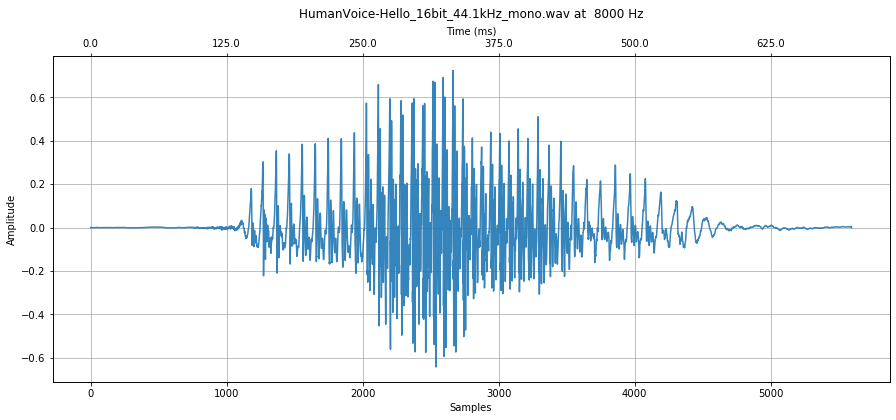

In [13]:
soundfile = 'HumanVoice-Hello_16bit_44.1kHz_mono.wav'
audio_data, sampling_rate = librosa.load(soundfile, sr=8000)

print(f"Sampling rate: {sampling_rate} Hz")
print(f"Number of channels = {len(audio_data.shape)}")
print(f"Total samples: {audio_data.shape[0]}")
print(f"Total time: {audio_data.shape[0] / sampling_rate} secs")


title = f"{soundfile} at  {sampling_rate} Hz" 
makelab.signal.plot_signal(audio_data, sampling_rate, title = title)

ipd.Audio(audio_data, rate=sampling_rate)

IndexError: index 2 is out of bounds for axis 0 with size 2

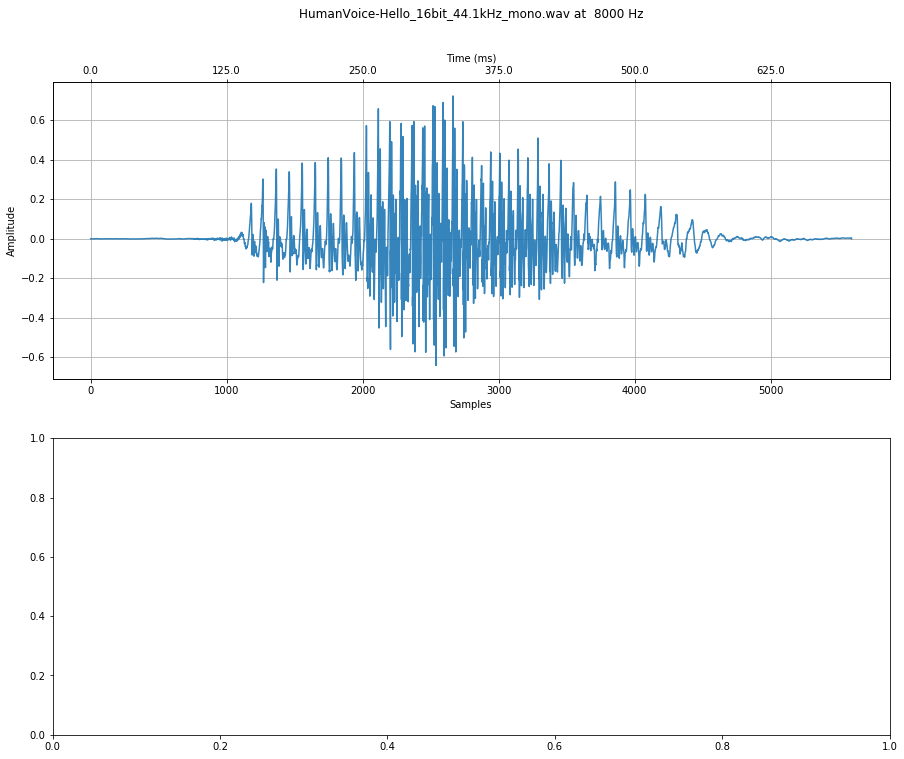

In [19]:
result = magnitude_spec(audio_data, sampling_rate, 
                        time_domain_graph_title = title,
                        include_annotations = False)

This tutorial needs love!!